In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, Normalize

import discretize 
from simpeg import maps
from simpeg.electromagnetics import time_domain as tdem

from simpeg.utils.solver_utils import get_default_solver

from simpeg.meta import MultiprocessingMetaSimulation #, DaskMetaSimulation

In [2]:
Solver = get_default_solver()
Solver

pymatsolver.direct.mumps.Mumps

# set up models and mesh

In [3]:
rho_back = 150
sigma_back = 1./rho_back 

rho_target = 20
sigma_target = 1./rho_target

sigma_air = 1e-8

target_dips = np.r_[0, 15, 30, 45]
target_z = np.r_[-70, -40]

In [4]:
tx_height = np.r_[30]

rx_x = (np.linspace(-500, 500, 51) + 5)[::2]
rx_y = np.r_[0]
rx_z = tx_height

rx_locs = discretize.utils.ndgrid([rx_x, rx_y, rx_z])
rx_x

array([-495., -455., -415., -375., -335., -295., -255., -215., -175.,
       -135.,  -95.,  -55.,  -15.,   25.,   65.,  105.,  145.,  185.,
        225.,  265.,  305.,  345.,  385.,  425.,  465.,  505.])

In [65]:
base_cell_width = 10
domain_extent = 8000

n_base_cells = 2 ** int(
    np.ceil(np.log(domain_extent / base_cell_width) / np.log(2.0))
)  # needs to be powers of 2 for the tree mesh

h = [(base_cell_width, n_base_cells)]
mesh = discretize.TreeMesh([h, h, h], origin="CCC", diagonal_balance=True)

# refine near transmitters and receivers
mesh.refine_points(
    rx_locs, level=-1, padding_cells_by_level=[2, 2, 4], 
    finalize=False, diagonal_balance=True
)

# Refine core region of the mesh 

bounding_points = np.array([
    [rx_x.min(), rx_y.min(), target_z.min()*3 - base_cell_width * 4], 
    [rx_x.max(), rx_y.max(), 0],
])
mesh.refine_bounding_box(
    bounding_points, level=-1, 
    diagonal_balance=True, finalize=False, padding_cells_by_level=[2, 4, 8]
)

mesh.finalize()

In [66]:
mesh

OcTreeMesh,0.01% filled
Level,Number of cells
3,448
4,416
5,480
6,1296
7,3744
8,32328
9,14358
10,27984
Total,81054


In [67]:
def dipping_target_indices(
    mesh, target_x_center, target_z_center, dip, target_thickness, target_xlim=None, target_ylim=None, target_zlim=None
): 
    """
    add a dipping target to the model. For now assumes the target dips in the x-direction
    """
    x_center = np.mean(target_x)
    slope = np.tan(-dip*np.pi/180)
    target_z = target_z_center + target_thickness / 2 * np.r_[-1, 1]
    
    z_bottom = (mesh.cell_centers[:, 0] - target_x_center) * slope + target_z.min()
    z_top = (mesh.cell_centers[:, 0] - target_x_center) * slope + target_z.max()

    indices = (
        (mesh.cell_centers[:, 2] >= z_bottom) &
        (mesh.cell_centers[:, 2] <= z_top) 
    )

    if target_xlim is not None: 
        indices = indices & (
            (mesh.cell_centers[:, 0] >= target_xlim.min()) &
            (mesh.cell_centers[:, 0] <= target_xlim.max())
        )
    if target_ylim is not None: 
        indices = indices & (
            (mesh.cell_centers[:, 1] >= target_ylim.min()) &
            (mesh.cell_centers[:, 1] <= target_ylim.max())
        )
    if target_zlim is not None: 
        indices = indices & (
            (mesh.cell_centers[:, 2] >= target_zlim.min()) &
            (mesh.cell_centers[:, 2] <= target_zlim.max())
        )
    return indices

In [68]:
models = {}

target_x = np.r_[-400, 500]
target_y = np.r_[-400, 500]
target_thickness = 45

# background model
background = np.ones(mesh.n_cells) * sigma_air
background[mesh.cell_centers[:, 2] < 0] = sigma_back
models["background"] = background

for dip in target_dips:
    model = background.copy()
    indices = dipping_target_indices(
        mesh, target_x_center=-100, target_z_center=-60, 
        target_thickness=target_thickness, dip=dip, 
        target_xlim=np.r_[-400, 400], 
        target_ylim=np.r_[-400, 400],
        target_zlim=np.r_[-200, -20]
    )
    model[indices] = sigma_target
    models[f"target_{dip}"] = model



In [69]:
indices

array([False, False, False, ..., False, False, False], shape=(81054,))

In [70]:
model_keys = list(models.keys())
model_keys

['background', 'target_0', 'target_15', 'target_30', 'target_45']

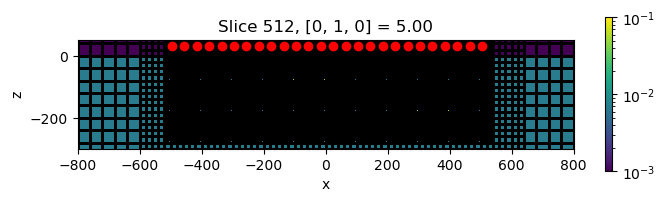

In [71]:
fig, ax = plt.subplots(1, 1, figsize=(8, 2)) 

plt.colorbar(
    mesh.plot_slice(
        models["target_15"], 
        grid=True, 
        normal="y",
        pcolor_opts={"norm":LogNorm(1e-3, 1e-1)},
        ax=ax)[0], 
    ax=ax
)

ax.set_xlim(800*np.r_[-1, 1])
ax.set_ylim(np.r_[-300, 50])

ax.plot(rx_locs[:, 0], rx_locs[:, 2], "ro")
ax.set_aspect(1)

In [72]:
active_cells_map = maps.InjectActiveCells(mesh, mesh.cell_centers[:, 2]<0, value_inactive=np.log(1e-8))

In [73]:
rx_times = np.logspace(np.log10(2e-5), np.log10(8e-3), 20)

In [74]:
source_list = []

for i in range(rx_locs.shape[0]): 
    rx = tdem.receivers.PointMagneticFluxTimeDerivative(rx_locs[i, :], rx_times, orientation="z")
    src = tdem.sources.CircularLoop(
        rx_list=[rx], location=rx_locs[i, :], orientation="z", radius=10, 
        waveform=tdem.sources.StepOffWaveform()
    )
    source_list.append(src)

survey = tdem.Survey(source_list)

In [75]:
# set up the survey

time_steps = [
    (1e-5, 40), (3e-5, 20), (1e-4, 20), (3e-4, 20)
]

In [76]:
global_sim = tdem.simulation.Simulation3DElectricField(
    mesh=mesh,
    survey=survey,
    time_steps=time_steps,
    solver=Solver,
    sigmaMap=maps.ExpMap() * active_cells_map
)

In [77]:
refine_depth = 180 # refine our local mesh to 200m 
mesh_list = []

for src in source_list: 
    mesh_local = discretize.TreeMesh(mesh.h, origin=mesh.origin, diagonal_balance=True)
    
    # refine near transmitters and receivers
    refine_points = discretize.utils.ndgrid(
        np.r_[src.location[0]], np.r_[src.location[1]], np.linspace(-refine_depth, src.location[2], 40)
    )
    mesh_local.refine_points(
        refine_points, level=-1, padding_cells_by_level=[2, 4, 8], 
        finalize=True, diagonal_balance=True
    )
    mesh_list.append(mesh_local)

In [78]:
mesh_list[1]

OcTreeMesh,0.00% filled
Level,Number of cells
2,16
3,336
4,320
5,376
6,744
7,1572
8,9144
9,2290
10,624


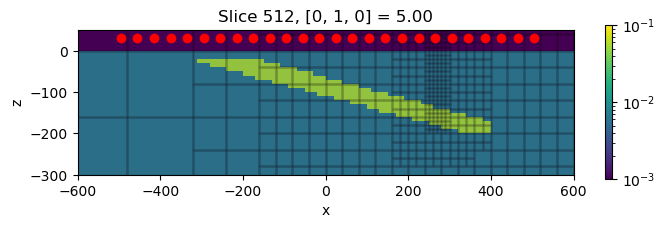

In [79]:
fig, ax = plt.subplots(1, 1, figsize=(8, 2)) 

mesh_local = mesh_list[19]

plt.colorbar(
    mesh.plot_slice(
        models["target_15"], 
        # grid=True, 
        normal="y",
        pcolor_opts={"norm":LogNorm(1e-3, 1e-1)},
        ax=ax)[0], 
    ax=ax
)
mesh_local.plot_slice(
    np.ones(mesh_local.n_cells), 
    # grid=True, 
    normal="y",
    grid_opts={"color":"k", "lw":1},
    pcolor_opts={"alpha":0.1},
    ax=ax
)
ax.set_xlim(600*np.r_[-1, 1])
ax.set_ylim(np.r_[-300, 50])

ax.plot(rx_locs[:, 0], rx_locs[:, 2], "ro")
ax.set_aspect(1)


In [80]:
active_cells_map.active_cells

array([ True,  True,  True, ..., False, False, False], shape=(81054,))

In [81]:
mappings = []
sims = []

for ii, local_mesh in enumerate(mesh_list):

    tile_map = maps.TileMap(mesh, active_cells_map.active_cells, local_mesh)
    mappings.append(tile_map)
    
    local_actmap = maps.InjectActiveCells(
        local_mesh, 
        active_cells=tile_map.local_active, 
        value_inactive=np.log(1e-8)
    )
    
    local_survey = tdem.Survey([survey.source_list[ii]])
    sims.append(tdem.simulation.Simulation3DElectricField(
            mesh=local_mesh,
            survey=local_survey,
            time_steps=time_steps,
            solver=Solver,
            sigmaMap=maps.ExpMap() * local_actmap
        )
    )

# client = Client()

sim = MultiprocessingMetaSimulation(sims, mappings)


In [82]:
log_conductivity_models = {}

for key, val in models.items():
    log_conductivity_models[key] = np.log(val[active_cells_map.active_cells])

In [83]:
np.exp(log_conductivity_models[key].max())

np.float64(0.05000000000000001)

In [84]:
ind = 0
tmp = sim.mappings[ind] * log_conductivity_models[key]

In [85]:
tile_map = sim.mappings[ind]
tile_map

In [86]:
P = discretize.utils.sdiag(1./tile_map.P.sum(1)) @ tile_map.P

In [87]:
testme = discretize.utils.mkvc(P.sum(1))

In [88]:
np.unique(testme)

array([1.])

In [89]:
np.exp(tmp.min())

np.float64(0.006666666666664187)

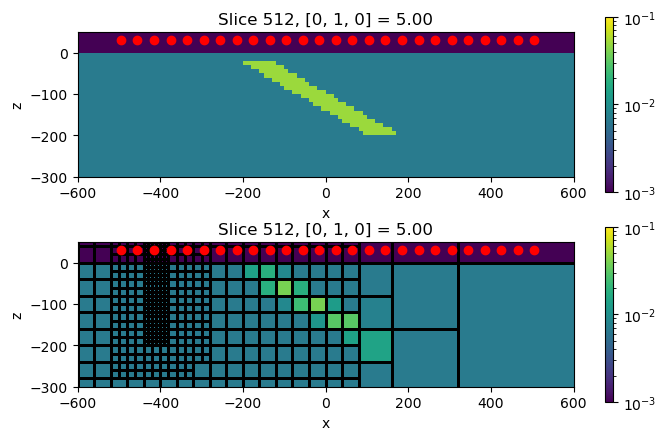

In [90]:
ind = 2
key = model_keys[3]
m_plot = sims[ind].sigmaMap * sim.mappings[ind] * log_conductivity_models[key]

fig, ax = plt.subplots(2, 1, figsize=(8, 5)) 

mesh_local = mesh_list[ind]

plt.colorbar(
    mesh.plot_slice(
        models[key], 
        # grid=True, 
        normal="y",
        pcolor_opts={"norm":LogNorm(1e-3, 1e-1)},
        ax=ax[0])[0], 
    ax=ax[0]
)

plt.colorbar(
    mesh_local.plot_slice(
        m_plot, 
        grid=True, 
        normal="y",
        pcolor_opts={"norm":LogNorm(1e-3, 1e-1)},
        ax=ax[1])[0], 
    ax=ax[1]
)

for a in ax:
    a.set_xlim(600*np.r_[-1, 1])
    a.set_ylim(np.r_[-300, 50])
    
    a.plot(rx_locs[:, 0], rx_locs[:, 2], "ro")
    a.set_aspect(1)



In [91]:
fields = {}
dpred = {}

key = model_keys[0]
model = log_conductivity_models[key]
fields[key] = sim.fields(model)

/Users/lindseyjh/git/simpeg/geoana/geoana/spatial.py:104: RuntimeWarning: invalid value encountered in multiply
  vec[..., 0] * np.cos(grid[..., 1]) - vec[..., 1] * np.sin(grid[..., 1]),
/Users/lindseyjh/git/simpeg/geoana/geoana/spatial.py:104: RuntimeWarning: invalid value encountered in multiply
  vec[..., 0] * np.cos(grid[..., 1]) - vec[..., 1] * np.sin(grid[..., 1]),
/Users/lindseyjh/git/simpeg/geoana/geoana/spatial.py:104: RuntimeWarning: invalid value encountered in multiply
  vec[..., 0] * np.cos(grid[..., 1]) - vec[..., 1] * np.sin(grid[..., 1]),
/Users/lindseyjh/miniforge3/envs/py311/lib/python3.11/site-packages/pymatsolver/solvers.py:415: FutureWarning: In Future pymatsolver v0.4.0, passing a vector of shape (n, 1) to the solve method will return an array with shape (n, 1), instead of always returning a flattened array. This is to be consistent with numpy.linalg.solve broadcasting.
  return self.solve(val)
/Users/lindseyjh/git/simpeg/geoana/geoana/spatial.py:104: RuntimeWarni

In [92]:
dpred[key] = sim.dpred(model, f=fields[key])